In [1]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
df = pd.read_csv('applications data.csv')
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,20160101,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,19070626,1797504115,0
1,2,20160101,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,20160101,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,20160101,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,20160101,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0


#### fix datetype

In [3]:
df['date'] = pd.to_datetime(df.date.astype(str).apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:]))
df['zip5'] = df['zip5'].apply(lambda x:'{0:0>5}'.format(x))

#### fix frivolous values

In [4]:
# ssn
df.loc[df.ssn==999999999,'ssn'] = -df.loc[df.ssn==999999999,'record']
df['ssn'] = df['ssn'].apply(lambda x:'{0:0>9}'.format(x))

In [5]:
# address
df.loc[df['address']=='123 MAIN ST','address'] = df.loc[df['address']=='123 MAIN ST','record'].apply(lambda x: str(x)+'RECORD')

In [6]:
# dob
df.loc[df['dob']==19070626,'dob'] = -df.loc[df.dob==19070626,'record']
df['dob'] = df['dob'].apply(lambda x: '{0:0>8}'.format(x))

In [7]:
# homephone
df.loc[df['homephone']==9999999999,'homephone'] = -df.loc[df['homephone']==9999999999,'record']
df['homephone'] = df['homephone'].apply(lambda x: '{0:0>10}'.format(x))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   record       1000000 non-null  int64         
 1   date         1000000 non-null  datetime64[ns]
 2   ssn          1000000 non-null  object        
 3   firstname    1000000 non-null  object        
 4   lastname     1000000 non-null  object        
 5   address      1000000 non-null  object        
 6   zip5         1000000 non-null  object        
 7   dob          1000000 non-null  object        
 8   homephone    1000000 non-null  object        
 9   fraud_label  1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 76.3+ MB


#### Risk table for day of week

In [9]:
df['dow'] = df.date.apply(lambda x: calendar.day_name[x.weekday()])

In [10]:
train_test = df[df.date < '2016-11-01']

In [11]:
# do statistical smothing
c = 4
nmid = 20
y_avg = train_test['fraud_label'].mean()
y_dow = train_test.groupby('dow')['fraud_label'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
df['dow_risk'] = df.dow.map(y_dow_smooth)

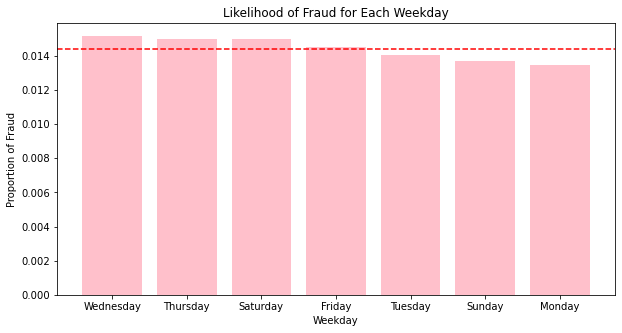

In [12]:
dow=pd.DataFrame(data=y_dow).sort_values('fraud_label',ascending=False)
plt.figure(figsize=(10,5))
plt.bar(dow.index,dow['fraud_label'],color='pink')
plt.xlabel('Weekday')
plt.ylabel('Proportion of Fraud')
plt.title('Likelihood of Fraud for Each Weekday')
plt.axhline(y=y_avg,color='red',linestyle="--")
plt.show()

#### Create entities

In [13]:
df['name'] = df.firstname + df.lastname
df['fulladdress'] = df.address + df.zip5
df['name_dob'] = df.name + df.dob
df['name_fulladdress'] = df.name + df.fulladdress
df['name_homephone'] = df.name + df.homephone
df['fulladdress_dob'] = df.fulladdress + df.dob
df['fulladdress_homephone'] = df.fulladdress + df.homephone
df['dob_homephone'] = df.dob + df.homephone 
df['homephone_name_dob'] = df.homephone + df.name_dob

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   record                 1000000 non-null  int64         
 1   date                   1000000 non-null  datetime64[ns]
 2   ssn                    1000000 non-null  object        
 3   firstname              1000000 non-null  object        
 4   lastname               1000000 non-null  object        
 5   address                1000000 non-null  object        
 6   zip5                   1000000 non-null  object        
 7   dob                    1000000 non-null  object        
 8   homephone              1000000 non-null  object        
 9   fraud_label            1000000 non-null  int64         
 10  dow                    1000000 non-null  object        
 11  dow_risk               1000000 non-null  float64       
 12  name                   100000

In [15]:
for field in list(df.iloc[:,np.r_[3:9, 12:15]].columns):
    df['ssn_'+field] = df.ssn + df[field]

In [16]:
attributes = list(df.iloc[:,np.r_[2,5,7,8,12:30]].columns)
attributes

['ssn',
 'address',
 'dob',
 'homephone',
 'name',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'name_homephone',
 'fulladdress_dob',
 'fulladdress_homephone',
 'dob_homephone',
 'homephone_name_dob',
 'ssn_firstname',
 'ssn_lastname',
 'ssn_address',
 'ssn_zip5',
 'ssn_dob',
 'ssn_homephone',
 'ssn_name',
 'ssn_fulladdress',
 'ssn_name_dob']

#### Velocity + Day since

In [17]:
df1 = df.copy()
final = df.copy()
df1['check_date'] = df1.date
df1['check_record'] = df1.record

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   record                 1000000 non-null  int64         
 1   date                   1000000 non-null  datetime64[ns]
 2   ssn                    1000000 non-null  object        
 3   firstname              1000000 non-null  object        
 4   lastname               1000000 non-null  object        
 5   address                1000000 non-null  object        
 6   zip5                   1000000 non-null  object        
 7   dob                    1000000 non-null  object        
 8   homephone              1000000 non-null  object        
 9   fraud_label            1000000 non-null  int64         
 10  dow                    1000000 non-null  object        
 11  dow_risk               1000000 non-null  float64       
 12  name                   100000

In [19]:
#start = time.timer() 
for entity in attributes:
    #st = timer()
    df_l = df1[['record','date',entity]]
    df_r = df1[['check_record','check_date', entity]]
    temp = pd.merge(df_l, df_r, how='left',on=entity)
    
    # day since
    day_since_df = temp[temp.record > temp.check_record][['record','date','check_date']].groupby('record')[['date', 'check_date']].last()
    mapper = (day_since_df.date - day_since_df.check_date).dt.days
    final[entity+'_day_since'] = final.record.map(mapper)
    final[entity+'_day_since'].fillna(365, inplace=True)
    print(f'\n{entity}_day_since ---> Done')
    
    # velocity
    for offset_t in [0,1,3,7,14,30,90,180]:
        count_day_df = temp[(temp.check_date >= (temp.date - dt.timedelta(offset_t)))&
                            (temp.record >= temp.check_record)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('record')[entity].count()
        final[col_name] = final.record.map(mapper2)
        print(f'{entity}_count_{str(offset_t)} ---> Done')
        
       # print(f'Run time for entity {entity} ----------- {timer() - st:0.2f}s')
#print(f'Total run time: {(timer() - start)/60:0.2f}min')
print('Done')


ssn_day_since ---> Done
ssn_count_0 ---> Done
ssn_count_1 ---> Done
ssn_count_3 ---> Done
ssn_count_7 ---> Done
ssn_count_14 ---> Done
ssn_count_30 ---> Done
ssn_count_90 ---> Done
ssn_count_180 ---> Done

address_day_since ---> Done
address_count_0 ---> Done
address_count_1 ---> Done
address_count_3 ---> Done
address_count_7 ---> Done
address_count_14 ---> Done
address_count_30 ---> Done
address_count_90 ---> Done
address_count_180 ---> Done

dob_day_since ---> Done
dob_count_0 ---> Done
dob_count_1 ---> Done
dob_count_3 ---> Done
dob_count_7 ---> Done
dob_count_14 ---> Done
dob_count_30 ---> Done
dob_count_90 ---> Done
dob_count_180 ---> Done

homephone_day_since ---> Done
homephone_count_0 ---> Done
homephone_count_1 ---> Done
homephone_count_3 ---> Done
homephone_count_7 ---> Done
homephone_count_14 ---> Done
homephone_count_30 ---> Done
homephone_count_90 ---> Done
homephone_count_180 ---> Done

name_day_since ---> Done
name_count_0 ---> Done
name_count_1 ---> Done
name_count_3 -

#### Relative Velocity

In [20]:
for att in attributes:
    for d in ['0','1']:
        for dd in ['3','7','14','30','90','180']:
            final[att+'_count_'+d+'_by_'+dd]\
                =final[att+'_count_'+d]/(final[att+'_count_'+dd]/float(dd))


In [21]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 492 entries, record to ssn_name_dob_count_1_by_180
dtypes: datetime64[ns](1), float64(287), int64(178), object(26)
memory usage: 3.7+ GB


In [22]:
stats = final.describe()
stats

,record,fraud_label,dow_risk,ssn_day_since,ssn_count_0,ssn_count_1,ssn_count_3,ssn_count_7,ssn_count_14,ssn_count_30,...,ssn_name_dob_count_0_by_14,ssn_name_dob_count_0_by_30,ssn_name_dob_count_0_by_90,ssn_name_dob_count_0_by_180,ssn_name_dob_count_1_by_3,ssn_name_dob_count_1_by_7,ssn_name_dob_count_1_by_14,ssn_name_dob_count_1_by_30,ssn_name_dob_count_1_by_90,ssn_name_dob_count_1_by_180
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,0.014410,327.100964,1.007305,1.014924,1.020140,1.026348,1.034591,1.050823,...,13.895295,29.588240,86.962905,170.196769,2.995696,6.976355,13.910634,29.620751,87.058962,170.385961
std,288675.278933,0.119104,0.000624,96.645429,0.223356,0.381210,0.423193,0.453557,0.477649,0.513331,...,0.889286,2.533416,11.656671,29.263552,0.079636,0.292048,0.801384,2.398072,11.410540,28.894681
min,1.000000,0.000000,0.013480,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.636364,1.363636,3.461538,4.615385,0.428571,0.500000,0.875000,1.764706,3.461538,4.615385
25%,250000.750000,0.000000,0.013674,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,14.000000,30.000000,90.000000,180.000000,3.000000,7.000000,14.000000,30.000000,90.000000,180.000000
50%,500000.500000,0.000000,0.014499,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,14.000000,30.000000,90.000000,180.000000,3.000000,7.000000,14.000000,30.000000,90.000000,180.000000
75%,750000.250000,0.000000,0.014981,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,14.000000,30.000000,90.000000,180.000000,3.000000,7.000000,14.000000,30.000000,90.000000,180.000000
max,1000000.000000,1.000000,0.015169,365.000000,21.000000,34.000000,34.000000,34.000000,34.000000,34.000000,...,14.000000,30.000000,90.000000,180.000000,3.000000,7.000000,14.000000,30.000000,90.000000,180.000000


In [23]:
stats = stats.loc[['min','max','mean','std'],:]
stats

,record,fraud_label,dow_risk,ssn_day_since,ssn_count_0,ssn_count_1,ssn_count_3,ssn_count_7,ssn_count_14,ssn_count_30,...,ssn_name_dob_count_0_by_14,ssn_name_dob_count_0_by_30,ssn_name_dob_count_0_by_90,ssn_name_dob_count_0_by_180,ssn_name_dob_count_1_by_3,ssn_name_dob_count_1_by_7,ssn_name_dob_count_1_by_14,ssn_name_dob_count_1_by_30,ssn_name_dob_count_1_by_90,ssn_name_dob_count_1_by_180
min,1.000000,0.000000,0.013480,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.636364,1.363636,3.461538,4.615385,0.428571,0.500000,0.875000,1.764706,3.461538,4.615385
max,1000000.000000,1.000000,0.015169,365.000000,21.000000,34.000000,34.000000,34.000000,34.000000,34.000000,...,14.000000,30.000000,90.000000,180.000000,3.000000,7.000000,14.000000,30.000000,90.000000,180.000000
mean,500000.500000,0.014393,0.014410,327.100964,1.007305,1.014924,1.020140,1.026348,1.034591,1.050823,...,13.895295,29.588240,86.962905,170.196769,2.995696,6.976355,13.910634,29.620751,87.058962,170.385961
std,288675.278933,0.119104,0.000624,96.645429,0.223356,0.381210,0.423193,0.453557,0.477649,0.513331,...,0.889286,2.533416,11.656671,29.263552,0.079636,0.292048,0.801384,2.398072,11.410540,28.894681


In [24]:
stats.to_csv('stats.csv')

### 2. Feature selection

In [25]:
from scipy.stats import ks_2samp
from numpy import random  

In [26]:
randomness=pd.Series(random.normal(0,1,size=1000000))

In [27]:
final['random']=randomness

In [28]:
final.describe()

,record,fraud_label,dow_risk,ssn_day_since,ssn_count_0,ssn_count_1,ssn_count_3,ssn_count_7,ssn_count_14,ssn_count_30,...,ssn_name_dob_count_0_by_30,ssn_name_dob_count_0_by_90,ssn_name_dob_count_0_by_180,ssn_name_dob_count_1_by_3,ssn_name_dob_count_1_by_7,ssn_name_dob_count_1_by_14,ssn_name_dob_count_1_by_30,ssn_name_dob_count_1_by_90,ssn_name_dob_count_1_by_180,random
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,0.014410,327.100964,1.007305,1.014924,1.020140,1.026348,1.034591,1.050823,...,29.588240,86.962905,170.196769,2.995696,6.976355,13.910634,29.620751,87.058962,170.385961,0.000751
std,288675.278933,0.119104,0.000624,96.645429,0.223356,0.381210,0.423193,0.453557,0.477649,0.513331,...,2.533416,11.656671,29.263552,0.079636,0.292048,0.801384,2.398072,11.410540,28.894681,0.999512
min,1.000000,0.000000,0.013480,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.363636,3.461538,4.615385,0.428571,0.500000,0.875000,1.764706,3.461538,4.615385,-5.781126
25%,250000.750000,0.000000,0.013674,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,90.000000,180.000000,3.000000,7.000000,14.000000,30.000000,90.000000,180.000000,-0.673718
50%,500000.500000,0.000000,0.014499,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,90.000000,180.000000,3.000000,7.000000,14.000000,30.000000,90.000000,180.000000,-0.000037
75%,750000.250000,0.000000,0.014981,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,90.000000,180.000000,3.000000,7.000000,14.000000,30.000000,90.000000,180.000000,0.675588
max,1000000.000000,1.000000,0.015169,365.000000,21.000000,34.000000,34.000000,34.000000,34.000000,34.000000,...,30.000000,90.000000,180.000000,3.000000,7.000000,14.000000,30.000000,90.000000,180.000000,4.570208


In [29]:
data=final[(final['date']<'2016-11-01')&(final['date']>'2016-01-14')]
data.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,...,ssn_name_dob_count_0_by_30,ssn_name_dob_count_0_by_90,ssn_name_dob_count_0_by_180,ssn_name_dob_count_1_by_3,ssn_name_dob_count_1_by_7,ssn_name_dob_count_1_by_14,ssn_name_dob_count_1_by_30,ssn_name_dob_count_1_by_90,ssn_name_dob_count_1_by_180,random
38511,38512,2016-01-15,476774243,RASTAZMM,EEJTAXEZ,1420 SJXAM WY,58008,19570328,7355086598,0,...,30.0,90.0,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.508135
38512,38513,2016-01-15,432844033,ESXAURS,SMJZXZMZ,2314 SZSRJ AVE,60458,19850530,0837788477,0,...,30.0,90.0,180.0,3.0,7.0,14.0,30.0,90.0,180.0,1.769462
38513,38514,2016-01-15,185477074,XMAEAEXSX,RTZRTZAS,9310 RMZTT AVE,65654,19180130,9130092903,0,...,30.0,90.0,180.0,3.0,7.0,14.0,30.0,90.0,180.0,-1.282392
38514,38515,2016-01-15,933119335,UUTXTTUAE,EMUTUJS,6950 XJERT AVE,56324,00-38515,0000-38515,0,...,30.0,90.0,180.0,3.0,7.0,14.0,30.0,90.0,180.0,-0.459818
38515,38516,2016-01-15,845202954,RTMMTSZRZ,SZJMSMUJ,4007 RTERR CT,50477,19271109,0000-38516,0,...,30.0,90.0,180.0,3.0,7.0,14.0,30.0,90.0,180.0,-0.510419


In [30]:
features=list(data.columns[30:492])
features.append('dow_risk')
features.append('random')
features.append('fraud_label')
features

['ssn_day_since',
 'ssn_count_0',
 'ssn_count_1',
 'ssn_count_3',
 'ssn_count_7',
 'ssn_count_14',
 'ssn_count_30',
 'ssn_count_90',
 'ssn_count_180',
 'address_day_since',
 'address_count_0',
 'address_count_1',
 'address_count_3',
 'address_count_7',
 'address_count_14',
 'address_count_30',
 'address_count_90',
 'address_count_180',
 'dob_day_since',
 'dob_count_0',
 'dob_count_1',
 'dob_count_3',
 'dob_count_7',
 'dob_count_14',
 'dob_count_30',
 'dob_count_90',
 'dob_count_180',
 'homephone_day_since',
 'homephone_count_0',
 'homephone_count_1',
 'homephone_count_3',
 'homephone_count_7',
 'homephone_count_14',
 'homephone_count_30',
 'homephone_count_90',
 'homephone_count_180',
 'name_day_since',
 'name_count_0',
 'name_count_1',
 'name_count_3',
 'name_count_7',
 'name_count_14',
 'name_count_30',
 'name_count_90',
 'name_count_180',
 'fulladdress_day_since',
 'fulladdress_count_0',
 'fulladdress_count_1',
 'fulladdress_count_3',
 'fulladdress_count_7',
 'fulladdress_count_14',

In [31]:
data=data[features]
data.head()

,ssn_day_since,ssn_count_0,ssn_count_1,ssn_count_3,ssn_count_7,ssn_count_14,ssn_count_30,ssn_count_90,ssn_count_180,address_day_since,...,ssn_name_dob_count_0_by_180,ssn_name_dob_count_1_by_3,ssn_name_dob_count_1_by_7,ssn_name_dob_count_1_by_14,ssn_name_dob_count_1_by_30,ssn_name_dob_count_1_by_90,ssn_name_dob_count_1_by_180,dow_risk,random,fraud_label
38511,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.014499,0.508135,0
38512,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.014499,1.769462,0
38513,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.014499,-1.282392,0
38514,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.014499,-0.459818,0
38515,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.014499,-0.510419,0


#### Calculate univariate KS

In [32]:
goods=data[data['fraud_label']==0]
bads=data[data['fraud_label']==1]

In [33]:
KSFDR=pd.DataFrame(features,columns=['variables'])
KSFDR

,variables
0,ssn_day_since
1,ssn_count_0
2,ssn_count_1
3,ssn_count_3
4,ssn_count_7
...,...
460,ssn_name_dob_count_1_by_90
461,ssn_name_dob_count_1_by_180
462,dow_risk
463,random


In [34]:
i=0
for column in features:
    KSFDR.loc[i,'ks']=ks_2samp(goods[column],bads[column])[0]  
    #ks_2samp returns two numbers: KS statistic and two-tailed p-value 
    i=i+1

In [35]:
 KSFDR

,variables,ks
0,ssn_day_since,0.227255
1,ssn_count_0,0.107093
2,ssn_count_1,0.148704
3,ssn_count_3,0.172102
4,ssn_count_7,0.193036
...,...,...
460,ssn_name_dob_count_1_by_90,0.150609
461,ssn_name_dob_count_1_by_180,0.143218
462,dow_risk,0.022088
463,random,0.007157


#### Calculate univariate FDR@3%

In [36]:
topRows = int(round(len(data)*0.03))
topRows

23850

In [37]:
numbads= int(len(bads.index))
numbads

11486

In [38]:
j = 0
for column in features[:-1]:
    temp = data[[column,'fraud_label']].copy()
    temp0 = temp.sort_values(column,ascending=False)
    temp1 = temp0.head(topRows)
    temp2 = temp0.tail(topRows)
    needed1 = temp1.loc[:,'fraud_label']
    needed2 = temp2.loc[:,'fraud_label']
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR.loc[j, 'FDR'] = FDRate
    j = j + 1


In [39]:
KSFDR.loc[464,'FDR']=1

In [40]:
KSFDR

,variables,ks,FDR
0,ssn_day_since,0.227255,0.253874
1,ssn_count_0,0.107093,0.134947
2,ssn_count_1,0.148704,0.175431
3,ssn_count_3,0.172102,0.198328
4,ssn_count_7,0.193036,0.218614
...,...,...,...
460,ssn_name_dob_count_1_by_90,0.150609,0.138429
461,ssn_name_dob_count_1_by_180,0.143218,0.137123
462,dow_risk,0.022088,0.033780
463,random,0.007157,0.030211


#### Sort by average rank

In [41]:
KSFDR['rank_ks'] = KSFDR['ks'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)

In [42]:
KSFDR['average_rank'] = (KSFDR['rank_ks'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['average_rank'], ascending=False,inplace=True)

In [43]:
KSFDR

,variables,ks,FDR,rank_ks,rank_FDR,average_rank
464,fraud_label,1.000000,1.000000,465.0,465.0,465.00
9,address_day_since,0.334096,0.355302,464.0,463.0,463.50
45,fulladdress_day_since,0.333210,0.358349,463.0,464.0,463.50
51,fulladdress_count_30,0.332032,0.354954,461.0,462.0,461.50
15,address_count_30,0.332725,0.353300,462.0,461.0,461.50
...,...,...,...,...,...,...
109,homephone_name_dob_count_0,0.001821,0.034825,5.0,6.5,5.75
82,fulladdress_dob_count_0,0.001812,0.034825,4.0,6.5,5.25
73,name_homephone_count_0,0.001782,0.034825,2.0,6.5,4.25
181,ssn_fulladdress_count_0,0.001774,0.034825,1.0,6.5,3.75


In [44]:
k1=KSFDR.sort_values(by=['rank_ks'], ascending=False)

In [45]:
k1=k1[['variables','ks','FDR','rank_ks']]


In [46]:
k1.to_csv('sort_by_ks.csv')

In [47]:
k2=KSFDR.sort_values(by=['rank_FDR'], ascending=False)

In [48]:
k2[['variables','ks','FDR','rank_FDR']]

,variables,ks,FDR,rank_FDR
464,fraud_label,1.000000,1.000000,465.0
45,fulladdress_day_since,0.333210,0.358349,464.0
9,address_day_since,0.334096,0.355302,463.0
51,fulladdress_count_30,0.332032,0.354954,462.0
15,address_count_30,0.332725,0.353300,461.0
...,...,...,...,...
109,homephone_name_dob_count_0,0.001821,0.034825,6.5
163,ssn_homephone_count_0,0.001793,0.034738,4.0
462,dow_risk,0.022088,0.033780,3.0
245,homephone_count_1_by_180,0.053964,0.030820,2.0


In [49]:
k2.to_csv('sort_by_FDR.csv')

In [50]:
KSFDR[1:81]

,variables,ks,FDR,rank_ks,rank_FDR,average_rank
9,address_day_since,0.334096,0.355302,464.0,463.0,463.50
45,fulladdress_day_since,0.333210,0.358349,463.0,464.0,463.50
51,fulladdress_count_30,0.332032,0.354954,461.0,462.0,461.50
15,address_count_30,0.332725,0.353300,462.0,461.0,461.50
14,address_count_14,0.322252,0.345812,460.0,459.0,459.50
...,...,...,...,...,...,...
369,ssn_lastname_count_0_by_30,0.205344,0.232370,384.0,389.5,386.75
429,ssn_name_count_0_by_30,0.204321,0.231499,381.0,388.0,384.50
321,fulladdress_homephone_count_0_by_30,0.202064,0.228626,379.0,387.0,383.00
94,fulladdress_homephone_count_7,0.199751,0.225318,376.0,386.0,381.00


In [51]:
data

,ssn_day_since,ssn_count_0,ssn_count_1,ssn_count_3,ssn_count_7,ssn_count_14,ssn_count_30,ssn_count_90,ssn_count_180,address_day_since,...,ssn_name_dob_count_0_by_180,ssn_name_dob_count_1_by_3,ssn_name_dob_count_1_by_7,ssn_name_dob_count_1_by_14,ssn_name_dob_count_1_by_30,ssn_name_dob_count_1_by_90,ssn_name_dob_count_1_by_180,dow_risk,random,fraud_label
38511,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.014499,0.508135,0
38512,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.014499,1.769462,0
38513,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.014499,-1.282392,0
38514,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.014499,-0.459818,0
38515,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.014499,-0.510419,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833502,36.0,1,1,1,1,1,1,2,2,36.0,...,90.0,3.0,7.0,14.0,30.0,45.0,90.0,0.013480,-0.242686,0
833503,151.0,1,1,1,1,1,1,1,2,151.0,...,90.0,3.0,7.0,14.0,30.0,90.0,90.0,0.013480,-0.370194,0
833504,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.013480,0.147663,0
833505,365.0,1,1,1,1,1,1,1,1,365.0,...,180.0,3.0,7.0,14.0,30.0,90.0,180.0,0.013480,2.082466,0


In [52]:
wrapper_df = data.iloc[:,KSFDR[1:81].index]
wrapper_df

,address_day_since,fulladdress_day_since,fulladdress_count_30,address_count_30,address_count_14,address_count_90,fulladdress_count_90,fulladdress_count_14,address_count_180,fulladdress_count_180,...,ssn_dob_count_0_by_30,fulladdress_count_1_by_14,name_dob_count_0_by_30,ssn_name_dob_count_0_by_30,ssn_firstname_count_0_by_30,ssn_lastname_count_0_by_30,ssn_name_count_0_by_30,fulladdress_homephone_count_0_by_30,fulladdress_homephone_count_7,name_day_since
38511,365.0,365.0,1,1,1,1,1,1,1,1,...,30.0,14.0,30.0,30.0,30.0,30.0,30.0,30.0,1,365.0
38512,365.0,365.0,1,1,1,1,1,1,1,1,...,30.0,14.0,30.0,30.0,30.0,30.0,30.0,30.0,1,365.0
38513,365.0,365.0,1,1,1,1,1,1,1,1,...,30.0,14.0,30.0,30.0,30.0,30.0,30.0,30.0,1,365.0
38514,365.0,365.0,1,1,1,1,1,1,1,1,...,30.0,14.0,30.0,30.0,30.0,30.0,30.0,30.0,1,365.0
38515,365.0,365.0,1,1,1,1,1,1,1,1,...,30.0,14.0,30.0,30.0,30.0,30.0,30.0,30.0,1,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833502,36.0,36.0,1,1,1,2,2,1,2,2,...,30.0,14.0,30.0,30.0,30.0,30.0,30.0,30.0,1,36.0
833503,151.0,151.0,1,1,1,1,1,1,2,2,...,30.0,14.0,30.0,30.0,30.0,30.0,30.0,30.0,1,151.0
833504,365.0,365.0,1,1,1,1,1,1,1,1,...,30.0,14.0,30.0,30.0,30.0,30.0,30.0,30.0,1,365.0
833505,365.0,365.0,1,1,1,1,1,1,1,1,...,30.0,14.0,30.0,30.0,30.0,30.0,30.0,30.0,1,365.0


### Backward selection

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV,RFE

In [54]:
#model = LogisticRegression(penalty='l2', class_weight='balanced')
#rfecv = RFECV(estimator=model, step=1, cv=2, verbose=0, n_jobs=1, scoring="roc_auc")
#rfecv.fit(wrapper_df,data['fraud_label'])

In [55]:
model = LogisticRegression(penalty='l2', class_weight='balanced')
rfe = RFE(estimator=model, n_features_to_select=50, step=1, verbose=0)
rfe.fit(wrapper_df,data['fraud_label'])

/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

RFE(estimator=LogisticRegression(class_weight='balanced'),
    n_features_to_select=50)

### Sort the variables by importance

In [56]:
#var_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv.ranking_), wrapper_df.columns)),
                            #columns = ['ranking', 'variable'])
#print(var_selected)

In [57]:
from matplotlib import pyplot as plt

In [58]:
#plt.figure()
#plt.xlabel('Number of features selected')
#plt.ylabel('Cross validation score (nb of correct classifications)')
#plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)

In [59]:
var_selected1 = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfe.ranking_), wrapper_df.columns)),
                            columns = ['ranking', 'variable'])
print(var_selected1)

    ranking                variable
0         1   address_count_0_by_14
1         1    address_count_0_by_3
2         1    address_count_0_by_7
3         1         address_count_1
4         1        address_count_14
..      ...                     ...
75       27  ssn_name_count_0_by_30
76       28   address_count_0_by_30
77       29       address_day_since
78       30          name_day_since
79       31  address_count_0_by_180

[80 rows x 2 columns]


In [60]:
var_selected1[:50]

,ranking,variable
0,1,address_count_0_by_14
1,1,address_count_0_by_3
2,1,address_count_0_by_7
3,1,address_count_1
4,1,address_count_14
5,1,address_count_3
6,1,address_count_30
7,1,fulladdress_count_0_by_14
8,1,fulladdress_count_0_by_3
9,1,fulladdress_count_0_by_7


In [61]:
a=list()
for i in var_selected1[:50]['variable']:
    a.append(i)
print(a)

['address_count_0_by_14', 'address_count_0_by_3', 'address_count_0_by_7', 'address_count_1', 'address_count_14', 'address_count_3', 'address_count_30', 'fulladdress_count_0_by_14', 'fulladdress_count_0_by_3', 'fulladdress_count_0_by_7', 'fulladdress_count_1', 'fulladdress_count_14', 'fulladdress_count_180', 'fulladdress_count_3', 'fulladdress_count_30', 'fulladdress_count_7', 'fulladdress_count_90', 'fulladdress_homephone_count_0_by_30', 'fulladdress_homephone_count_180', 'fulladdress_homephone_count_30', 'fulladdress_homephone_count_7', 'name_dob_count_0_by_30', 'name_dob_count_14', 'name_dob_count_180', 'name_dob_count_30', 'name_dob_count_90', 'ssn_count_14', 'ssn_count_180', 'ssn_count_30', 'ssn_dob_count_14', 'ssn_dob_count_180', 'ssn_dob_count_30', 'ssn_dob_count_90', 'ssn_dob_day_since', 'ssn_firstname_count_14', 'ssn_firstname_count_180', 'ssn_firstname_count_30', 'ssn_firstname_count_90', 'ssn_lastname_count_14', 'ssn_lastname_count_30', 'ssn_lastname_count_90', 'ssn_name_coun

In [62]:
wrapper_df1=data.loc[:,a]
wrapper_df1

,address_count_0_by_14,address_count_0_by_3,address_count_0_by_7,address_count_1,address_count_14,address_count_3,address_count_30,fulladdress_count_0_by_14,fulladdress_count_0_by_3,fulladdress_count_0_by_7,...,ssn_lastname_count_90,ssn_name_count_14,ssn_name_count_30,ssn_name_count_90,ssn_name_dob_count_0_by_30,ssn_name_dob_count_14,ssn_name_dob_count_180,ssn_name_dob_count_30,ssn_name_dob_count_90,ssn_name_dob_day_since
38511,14.0,3.0,7.0,1,1,1,1,14.0,3.0,7.0,...,1,1,1,1,30.0,1,1,1,1,365.0
38512,14.0,3.0,7.0,1,1,1,1,14.0,3.0,7.0,...,1,1,1,1,30.0,1,1,1,1,365.0
38513,14.0,3.0,7.0,1,1,1,1,14.0,3.0,7.0,...,1,1,1,1,30.0,1,1,1,1,365.0
38514,14.0,3.0,7.0,1,1,1,1,14.0,3.0,7.0,...,1,1,1,1,30.0,1,1,1,1,365.0
38515,14.0,3.0,7.0,1,1,1,1,14.0,3.0,7.0,...,1,1,1,1,30.0,1,1,1,1,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833502,14.0,3.0,7.0,1,1,1,1,14.0,3.0,7.0,...,2,1,1,2,30.0,1,2,1,2,36.0
833503,14.0,3.0,7.0,1,1,1,1,14.0,3.0,7.0,...,1,1,1,1,30.0,1,2,1,1,151.0
833504,14.0,3.0,7.0,1,1,1,1,14.0,3.0,7.0,...,1,1,1,1,30.0,1,1,1,1,365.0
833505,14.0,3.0,7.0,1,1,1,1,14.0,3.0,7.0,...,1,1,1,1,30.0,1,1,1,1,365.0


In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

In [64]:
#model2=KNeighborsClassifier(n_neighbors=4)
#rfecv2=RFECV(estimator=model,step=1,cv=2,verbose=0,n_jobs=1,scoring="roc_auc")
#rfecv2.fit(wrapper_df1, data['fraud_label'])

In [65]:
#model2=KNeighborsClassifier(n_neighbors=4)
#rfe1 = RFE(estimator=model2, n_features_to_select=30, step=1, verbose=0)
#rfe1.fit(wrapper_df1,data['fraud_label'])

In [66]:
clf = tree.DecisionTreeClassifier()
rfe1 = RFE(estimator=clf, n_features_to_select=30, step=1, verbose=0)
rfe1.fit(wrapper_df1,data['fraud_label'])

RFE(estimator=DecisionTreeClassifier(), n_features_to_select=30)

In [67]:
#model = LogisticRegression(penalty='l2', class_weight='balanced')
#rfecv = RFECV(estimator=model, step=1, cv=2, verbose=0, n_jobs=1, scoring="roc_auc")
#rfecv.fit(wrapper_df1,data['fraud_label'])

In [68]:
var_selected2 = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfe1.ranking_), wrapper_df1.columns)),
                            columns = ['ranking', 'variable'])
print(var_selected2)

    ranking                             variable
0         1                address_count_0_by_14
1         1                 address_count_0_by_3
2         1                 address_count_0_by_7
3         1                      address_count_1
4         1                     address_count_14
5         1                      address_count_3
6         1                     address_count_30
7         1            fulladdress_count_0_by_14
8         1             fulladdress_count_0_by_3
9         1             fulladdress_count_0_by_7
10        1                  fulladdress_count_1
11        1                fulladdress_count_180
12        1                 fulladdress_count_30
13        1                  fulladdress_count_7
14        1                 fulladdress_count_90
15        1  fulladdress_homephone_count_0_by_30
16        1      fulladdress_homephone_count_180
17        1       fulladdress_homephone_count_30
18        1        fulladdress_homephone_count_7
19        1         

In [69]:
var_selected2[:30].to_csv('var_selected.csv')

### 3. Model exploration

In [70]:
varlist = ['date',
'address_count_0_by_14',
'address_count_0_by_3',
'address_count_0_by_7',
'address_count_3',
'address_count_30',
'fulladdress_count_0_by_3',
'fulladdress_count_0_by_30',
'fulladdress_count_0_by_7',
'fulladdress_count_1',
'fulladdress_count_180',
'fulladdress_count_1_by_14',
'fulladdress_count_30',
'fulladdress_count_7',
'fulladdress_count_90',
'fulladdress_homephone_count_14',
'fulladdress_homephone_count_180',
'fulladdress_homephone_count_30',
'fulladdress_homephone_count_7',
'name_dob_count_0_by_30',
'name_dob_count_180',
'name_dob_count_30',
'ssn_count_14',
'ssn_count_30',
'ssn_dob_count_180',
'ssn_dob_count_90',
'ssn_dob_day_since',
'ssn_firstname_count_180',
'ssn_lastname_count_90',
'ssn_name_dob_count_14',
'ssn_name_dob_day_since',
'fraud_label']

In [71]:
df = final
df = df[varlist]
#df.to_csv('my30feature.csv', index=False)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   date                             1000000 non-null  datetime64[ns]
 1   address_count_0_by_14            1000000 non-null  float64       
 2   address_count_0_by_3             1000000 non-null  float64       
 3   address_count_0_by_7             1000000 non-null  float64       
 4   address_count_3                  1000000 non-null  int64         
 5   address_count_30                 1000000 non-null  int64         
 6   fulladdress_count_0_by_3         1000000 non-null  float64       
 7   fulladdress_count_0_by_30        1000000 non-null  float64       
 8   fulladdress_count_0_by_7         1000000 non-null  float64       
 9   fulladdress_count_1              1000000 non-null  int64         
 10  fulladdress_count_180          

In [5]:
#df = pd.read_csv('30feature.csv')
df.head()

,date,address_count_0_by_14,address_count_0_by_3,address_count_0_by_7,address_count_3,address_count_30,fulladdress_count_0_by_3,fulladdress_count_0_by_30,fulladdress_count_0_by_7,fulladdress_count_1,...,ssn_count_14,ssn_count_30,ssn_dob_count_180,ssn_dob_count_90,ssn_dob_day_since,ssn_firstname_count_180,ssn_lastname_count_90,ssn_name_dob_count_14,ssn_name_dob_day_since,fraud_label
0,2016-01-01,14.0,3.0,7.0,1,1,3.0,30.0,7.0,1,...,1,1,1,1,365.0,1,1,1,365.0,0
1,2016-01-01,14.0,3.0,7.0,1,1,3.0,30.0,7.0,1,...,1,1,1,1,365.0,1,1,1,365.0,1
2,2016-01-01,14.0,3.0,7.0,1,1,3.0,30.0,7.0,1,...,1,1,1,1,365.0,1,1,1,365.0,0
3,2016-01-01,14.0,3.0,7.0,1,1,3.0,30.0,7.0,1,...,1,1,1,1,365.0,1,1,1,365.0,0
4,2016-01-01,14.0,3.0,7.0,1,1,3.0,30.0,7.0,1,...,1,1,1,1,365.0,1,1,1,365.0,0


In [6]:
oot = df.loc[df['date']>='2016-11-01']

In [7]:
train_test = df.loc[(df['date']>'2016-01-14')&(df['date']<'2016-11-01')]

In [8]:
train_test.head()

,date,address_count_0_by_14,address_count_0_by_3,address_count_0_by_7,address_count_3,address_count_30,fulladdress_count_0_by_3,fulladdress_count_0_by_30,fulladdress_count_0_by_7,fulladdress_count_1,...,ssn_count_14,ssn_count_30,ssn_dob_count_180,ssn_dob_count_90,ssn_dob_day_since,ssn_firstname_count_180,ssn_lastname_count_90,ssn_name_dob_count_14,ssn_name_dob_day_since,fraud_label
38511,2016-01-15,14.0,3.0,7.0,1,1,3.0,30.0,7.0,1,...,1,1,1,1,365.0,1,1,1,365.0,0
38512,2016-01-15,14.0,3.0,7.0,1,1,3.0,30.0,7.0,1,...,1,1,1,1,365.0,1,1,1,365.0,0
38513,2016-01-15,14.0,3.0,7.0,1,1,3.0,30.0,7.0,1,...,1,1,1,1,365.0,1,1,1,365.0,0
38514,2016-01-15,14.0,3.0,7.0,1,1,3.0,30.0,7.0,1,...,1,1,1,1,365.0,1,1,1,365.0,0
38515,2016-01-15,14.0,3.0,7.0,1,1,3.0,30.0,7.0,1,...,1,1,1,1,365.0,1,1,1,365.0,0


In [9]:
X_oot = oot.iloc[:,1:-1].values
y_oot = oot.iloc[:,-1].values

In [10]:
from sklearn.model_selection import train_test_split
X = train_test.iloc[:,1:-1].values
y = train_test.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

In [11]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2',class_weight='balanced',random_state=1, max_iter=500)
model.fit(X_train, y_train)

/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=500, random_state=1)

In [12]:
from sklearn.metrics import roc_auc_score
y_train_pred = model.predict(X_train)
print('training data AUC: ',roc_auc_score(y_train, y_train_pred))
y_test_pred = model.predict(X_test)
print('testing data AUC: ',roc_auc_score(y_test, y_test_pred))
X_oot = oot.iloc[:,1:-1]
y_oot = oot.iloc[:,-1]
y_oot_pred = model.predict(X_oot)
print('OOT data AUC: ',roc_auc_score(y_oot, y_oot_pred))

training data AUC:  0.7554143813285761
testing data AUC:  0.7448009713986421
OOT data AUC:  0.7402824323657621


In [13]:
feature_importance = pd.DataFrame({'feature':df.columns[1:-1],
                                   'coef':model.coef_[0]}).sort_values('coef', ascending=False)
feature_importance

,feature,coef
11,fulladdress_count_30,1.331550
20,name_dob_count_30,1.244154
8,fulladdress_count_1,1.072441
16,fulladdress_homephone_count_30,0.908442
9,fulladdress_count_180,0.538736
19,name_dob_count_180,0.457361
28,ssn_name_dob_count_14,0.340542
24,ssn_dob_count_90,0.307149
22,ssn_count_30,0.290323
4,address_count_30,0.288218


### Logistic

In [14]:
print('n\ttrain\t test\t OOT')
for n in [5,10,15,20,25,30]:
    feature_selected = feature_importance['feature'][:n]
    X = train_test.loc[:,feature_selected].values
    y = train_test.iloc[:,-1].values
    X_oot = oot.loc[:,feature_selected].values
    y_oot = oot.iloc[:,-1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
    model = LogisticRegression(penalty='l2',class_weight='balanced',max_iter=200,random_state=1)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_oot_pred = model.predict(X_oot)
    
    print(f'{n}\t{round(roc_auc_score(y_train, y_train_pred),3)}\t{round(roc_auc_score(y_test, y_test_pred),3)}\t{round(roc_auc_score(y_oot, y_oot_pred),3)}')

n	train	 test	 OOT
5	0.743	0.744	0.733
10	0.744	0.746	0.733


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


15	0.747	0.748	0.736


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


20	0.748	0.748	0.737


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


25	0.746	0.747	0.734
30	0.752	0.753	0.74


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
print('FDR:')
print('n\ttrain\t test\t OOT')
for n in [5,10,15,20,25,30]:
    feature_selected = feature_importance['feature'][:n]
    X = train_test.loc[:,feature_selected].values
    y = train_test.iloc[:,-1].values
    X_oot = oot.loc[:,feature_selected].values
    y_oot = oot.iloc[:,-1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)
    model = LogisticRegression(penalty='l2',class_weight='balanced',max_iter=100,random_state=1)
    model.fit(X_train, y_train)
    
    y_train_prob = model.predict_proba(X_train)[:,1]
    y_test_prob = model.predict_proba(X_test)[:,1]
    y_oot_prob = model.predict_proba(X_oot)[:,1]
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_oot_pred = model.predict(X_oot)
    
    train_fdr = pd.DataFrame({'y_train_prob':y_train_prob,'y_train_pred':y_train_pred,'y_train':y_train})
    train_fdr = train_fdr.sort_values('y_train_prob', ascending=False)
    train_numbads = len(train_fdr.loc[train_fdr['y_train']==1])
    train_top_rows = int(round(len(train_fdr)*0.03))
    train_head = train_fdr.head(train_top_rows)
    train_needed = len(train_head.loc[train_head['y_train']==1])
    train_fdr_val = train_needed/train_numbads
    
    y_test_prob = model.predict_proba(X_test)[:,1]
    test_fdr = pd.DataFrame({'y_test_prob':y_test_prob,'y_test_pred':y_test_pred,'y_test':y_test})
    test_fdr = test_fdr.sort_values('y_test_prob', ascending=False)
    test_numbads = len(test_fdr.loc[test_fdr['y_test']==1])
    test_top_rows = int(round(len(test_fdr)*0.03))
    test_head = test_fdr.head(test_top_rows)
    test_needed = len(test_head.loc[test_head['y_test']==1])
    test_fdr_val = test_needed/test_numbads
    
    y_oot_prob = model.predict_proba(X_oot)[:,1]
    oot_fdr = pd.DataFrame({'y_oot_prob':y_oot_prob,'y_oot_pred':y_oot_pred,'y_oot':y_oot})
    oot_fdr = oot_fdr.sort_values('y_oot_prob', ascending=False)
    oot_numbads = len(oot_fdr.loc[oot_fdr['y_oot']==1])
    oot_top_rows = int(round(len(oot_fdr)*0.03))
    oot_head = oot_fdr.head(oot_top_rows)
    oot_needed = len(oot_head.loc[oot_head['y_oot']==1])
    oot_fdr_val = oot_needed/oot_numbads

    print(f'{n}\t{round(train_fdr_val,3)}\t{round(test_fdr_val,3)}\t{round(oot_fdr_val,3)}')
    #print(f'{n}\t{round(roc_auc_score(y_train, y_train_pred),3)}\t{round(roc_auc_score(y_test, y_test_pred),3)}\t{round(roc_auc_score(y_oot, y_oot_pred),3)}')

FDR:
n	train	 test	 OOT
5	0.499	0.482	0.474
10	0.515	0.496	0.489


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


15	0.518	0.499	0.49


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


20	0.524	0.507	0.492


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


25	0.524	0.507	0.492


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


30	0.525	0.507	0.492


### Neural Net

In [16]:
from sklearn.neural_network import MLPClassifier

In [17]:
mlp = MLPClassifier(solver='sgd', activation='logistic',alpha=1e-4,hidden_layer_sizes=(10), random_state=1,max_iter=20)
mlp.fit(X_train, y_train)

/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=10, max_iter=20,
              random_state=1, solver='sgd')

In [18]:
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
y_oot_pred = mlp.predict(X_oot)
print('training data AUC: ',roc_auc_score(y_train,y_train_pred))
print('testing data AUC: ',roc_auc_score(y_test,y_test_pred))
print('OOT data AUC: ',roc_auc_score(y_oot,y_oot_pred))

training data AUC:  0.5808195302947463
testing data AUC:  0.5861273223078356
OOT data AUC:  0.5897074653075156


In [29]:
print('FDR:')
print('layer\tepoch\ttrain\t test\t OOT')
for hidden_layer_size in [(10),(15),(20)]:
    for epoch in [20,50]:
        model = MLPClassifier(solver='sgd', activation='logistic',alpha=1e-4,
                              hidden_layer_sizes=hidden_layer_size, random_state=1,max_iter=epoch)
        model.fit(X_train, y_train)

        y_train_prob = model.predict_proba(X_train)[:,1]
        y_test_prob = model.predict_proba(X_test)[:,1]
        y_oot_prob = model.predict_proba(X_oot)[:,1]

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        y_oot_pred = model.predict(X_oot)

        train_fdr = pd.DataFrame({'y_train_prob':y_train_prob,'y_train_pred':y_train_pred,'y_train':y_train})
        train_fdr = train_fdr.sort_values('y_train_prob', ascending=False)
        train_numbads = len(train_fdr.loc[train_fdr['y_train']==1])
        train_top_rows = int(round(len(train_fdr)*0.03))
        train_head = train_fdr.head(train_top_rows)
        train_needed = len(train_head.loc[train_head['y_train']==1])
        train_fdr_val = train_needed/train_numbads

        y_test_prob = model.predict_proba(X_test)[:,1]
        test_fdr = pd.DataFrame({'y_test_prob':y_test_prob,'y_test_pred':y_test_pred,'y_test':y_test})
        test_fdr = test_fdr.sort_values('y_test_prob', ascending=False)
        test_numbads = len(test_fdr.loc[test_fdr['y_test']==1])
        test_top_rows = int(round(len(test_fdr)*0.03))
        test_head = test_fdr.head(test_top_rows)
        test_needed = len(test_head.loc[test_head['y_test']==1])
        test_fdr_val = test_needed/test_numbads

        y_oot_prob = model.predict_proba(X_oot)[:,1]
        oot_fdr = pd.DataFrame({'y_oot_prob':y_oot_prob,'y_oot_pred':y_oot_pred,'y_oot':y_oot})
        oot_fdr = oot_fdr.sort_values('y_oot_prob', ascending=False)
        oot_numbads = len(oot_fdr.loc[oot_fdr['y_oot']==1])
        oot_top_rows = int(round(len(oot_fdr)*0.03))
        oot_head = oot_fdr.head(oot_top_rows)
        oot_needed = len(oot_head.loc[oot_head['y_oot']==1])
        oot_fdr_val = oot_needed/oot_numbads

        print(f'{hidden_layer_size}\t{epoch}\t{round(train_fdr_val,3)}\t{round(test_fdr_val,3)}\t{round(oot_fdr_val,3)}')


FDR:
layer	epoch	train	 test	 OOT


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


10	20	0.51	0.497	0.486


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


10	50	0.522	0.504	0.492


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


15	20	0.519	0.502	0.495


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


15	50	0.529	0.512	0.503


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


20	20	0.515	0.5	0.494


/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


20	50	0.52	0.501	0.496


### XGBoost

In [20]:
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_oot = scaler.transform(X_oot)


In [22]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:59:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
from sklearn.metrics import roc_auc_score
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_oot_pred = model.predict(X_oot)
print('training data AUC: ',roc_auc_score(y_train,y_train_pred))
print('testing data AUC: ',roc_auc_score(y_test,y_test_pred))
print('OOT data AUC: ',roc_auc_score(y_oot,y_oot_pred))

training data AUC:  0.745042467036219
testing data AUC:  0.7352764735869117
OOT data AUC:  0.7265673463683925


### Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [45]:
print('n\ttrain\t test\t OOT')
for n in [5,10,15,20,25,30]:
    feature_selected=list(feature_importance.feature[:n])
    X=train_test[feature_selected]
    y=train_test['fraud_label']
    X_oot=oot[feature_selected]
    y_oot=oot['fraud_label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
    model = RandomForestClassifier(n_estimators=100,min_samples_leaf=3,max_features=4) 
    model.fit(X_train, y_train)
    
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    y_oot_pred=model.predict(X_oot)
    print(f'{n}\t{round(roc_auc_score(y_train, y_train_pred),3)}\t{round(roc_auc_score(y_test, y_test_pred),3)}\t{round(roc_auc_score(y_oot, y_oot_pred),3)}')

n	train	 test	 OOT
5	0.734	0.723	0.721
10	0.735	0.724	0.721
15	0.745	0.733	0.73
20	0.745	0.732	0.732
25	0.741	0.728	0.727
30	0.747	0.732	0.732


In [48]:
print('FDR at 3%')
print('n\t#_trees\tmtry\ttrain\t test\t OOT')
for n in [20,30]:
    for i in [100,150]:
        for j in [5,10]:
            feature_selected=list(feature_importance.feature[:n])
            X=train_test[feature_selected]
            y=train_test['fraud_label']
            X_oot=oot[feature_selected]
            y_oot=oot['fraud_label']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
            model = RandomForestClassifier(n_estimators=i,min_samples_leaf=3,max_features=j) 
            model.fit(X_train, y_train)

            y_train_pred=model.predict(X_train)
            y_test_pred=model.predict(X_test)
            y_oot_pred=model.predict(X_oot)

            y_train_prob = model.predict_proba(X_train)[:,1]
            y_test_prob = model.predict_proba(X_test)[:,1]
            y_oot_prob = model.predict_proba(X_oot)[:,1]

            train_fdr = pd.DataFrame({'y_train_prob':y_train_prob,'y_train_pred':y_train_pred,'y_train':y_train}).sort_values('y_train_prob', ascending=False)
            train_numbads = len(train_fdr.loc[train_fdr['y_train']==1])
            train_top_rows = int(round(len(train_fdr)*0.03))
            train_head = train_fdr.head(train_top_rows)
            train_needed_0 = len(train_head.loc[train_head['y_train']==1])
            train_fdr_value = train_needed_0/train_numbads

            test_fdr = pd.DataFrame({'y_test_prob':y_test_prob,'y_test_pred':y_test_pred,'y_test':y_test}).sort_values('y_test_prob', ascending=False)
            test_numbads = len(test_fdr.loc[test_fdr['y_test']==1])
            test_top_rows = int(round(len(test_fdr)*0.03))
            test_head = test_fdr.head(test_top_rows)
            test_needed = len(test_head.loc[test_head['y_test']==1])
            test_fdr_value= test_needed/test_numbads

            oot_fdr = pd.DataFrame({'y_oot_prob':y_oot_prob,'y_oot_pred':y_oot_pred,'y_oot':y_oot}).sort_values('y_oot_prob', ascending=False)
            oot_numbads = len(oot_fdr.loc[oot_fdr['y_oot']==1])
            oot_top_rows = int(round(len(oot_fdr)*0.03))
            oot_head = oot_fdr.head(oot_top_rows)
            oot_needed = len(oot_head.loc[oot_head['y_oot']==1])
            oot_fdr_value = oot_needed/oot_numbads

            print(f'{n}\t{i}\t{j}\t{round(train_fdr_value,3)}\t{round(test_fdr_value,3)}\t{round(oot_fdr_value,3)}')

FDR at 3%
n	#_trees	mtry	train	 test	 OOT
20	100	5	0.539	0.515	0.509
20	100	10	0.539	0.514	0.509
20	150	5	0.539	0.514	0.51
20	150	10	0.539	0.514	0.509
30	100	5	0.55	0.518	0.519
30	100	10	0.551	0.516	0.516
30	150	5	0.55	0.518	0.522
30	150	10	0.551	0.515	0.515


### 4. Hyperparameter tuning

In [18]:
def fdr(model, X,y):
    y_prob = model.predict_proba(X)[:,1]
    fdr = pd.DataFrame({'y_prob':y_prob,'y':y})
    fdr = fdr.sort_values('y_prob', ascending=False)
    numbads = len(fdr.loc[fdr['y']==1])
    top_rows = int(round(len(fdr)*0.03))
    head = fdr.head(top_rows)
    needed = len(head.loc[head['y']==1])
    fdr_val = needed/numbads
    return fdr_val

In [53]:
%%time

gsc = GridSearchCV(
    #estimator=XGBClassifier(scale_pos_weight=1),
    estimator=XGBClassifier(#scale_pos_weight= (len(y_train)-sum(y_train)) / sum(y_train) ),
    param_grid={
        "max_depth":[2,3,4,5], # 2,3,4,5
        "subsample":[0.8],# 0.8,1
        "colsample_bytree":[0.8],# 0.5，0.8，1
        "learnineg_rate":[0.01,0.1,0.2,0.5], #0.01,0.1
        'min_child_weight': [5], # 1，3，5
        'n_estimators' : [500,1000,1500],# 100,500,1000,1500,2000
    
    },
    cv=3,n_jobs=5,scoring =fdr,verbose=4
)

grid_result = gsc.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 out of   9 | elapsed:  2.0min remaining:  4.1min
[Parallel(n_jobs=5)]: Done   6 out of   9 | elapsed:  4.7min remaining:  2.3min
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:  5.5min finished
/Users/tracy/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:15:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 14min 40s, sys: 13.7 s, total: 14min 54s
Wall time: 6min 48s


In [39]:
from sklearn import metrics
print("Best parameters : %s" % grid_result.best_params_)

pred01=gsc.predict(X_test)


print(confusion_matrix(y_test,pred01))

df01=pd.DataFrame({"true":y_test,"pred":pred01,"count":list(range(len(pred01)))})
df01_gb=df01.groupby(["true","pred"],as_index=False)["count"].count()
print(df01_gb)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred01, pos_label=1)
print(metrics.auc(fpr, tpr))
print(fdr(gsc, X_test, y_test))

Best parameters : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}
[[233459   1594]
 [  1627   1819]]
   true  pred   count
0     0     0  233459
1     0     1    1594
2     1     0    1627
3     1     1    1819
0.7605384686224765
0.539175856065003


# Final model

In [20]:
%%time
model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        max_depth=4, 
        subsample=0.8,
        colsample_bytree=0.8,
        learning_rate=0.01,
        #gamma=0.2,
        #reg_lambda=0.1,
        min_child_weight= 5,
        n_estimators=500,
        eval_metric=fdr, # cutoff %3 fdr 
        random_state=1,
        #early_stopping_rounds=100
        #scale_pos_weight= 3#(len(y_train)-sum(y_train)) / sum(y_train),
        )
model.fit(X_train, y_train)

[10:56:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 10min 6s, sys: 8.93 s, total: 10min 15s
Wall time: 55.6 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              eval_metric=<function fdr at 0x7fcf5a651ee0>, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=12, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
y_train_proba = model.predict_proba(X_train)[:,1]
y_test_proba = model.predict_proba(X_test)[:,1]
y_oot_proba = model.predict_proba(X_oot)[:,1]
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_oot_pred = model.predict(X_oot)

In [27]:
from sklearn.metrics import roc_auc_score
print('Train auc: ', round(roc_auc_score(y_train,y_train_pred),3))
print('Test auc: ', round(roc_auc_score(y_test,y_test_pred),3))
print('OOT auc: ', round(roc_auc_score(y_oot,y_oot_pred),3))
print('Train fdr: ',round(fdr(model, X_train, y_train),3))
print('Test fdr: ',round(fdr(model, X_test, y_test),3))
print('OOT fdr: ',round(fdr(model, X_oot, y_oot),3))

Train auc:  0.747
Test auc:  0.738
OOT auc:  0.735
Train fdr:  0.544
Test fdr:  0.523
OOT fdr:  0.518


In [48]:
df_train= pd.DataFrame({'predict':y_oot_proba, 'true':y_oot})
df_train = df_train.sort_values(by='predict', ascending=False)
df_train.reset_index(inplace=True)
total_num = y_oot.shape[0]
bin_num = int(total_num/100)
df_train['bin'] = 0
df_train.drop('index',inplace=True,axis=1)
line = 0
for i in range(101):
    line_end = line+bin_num
    if line_end>total_num:
        break
    else:
        df_train.iloc[line:line_end,2]=i+1
        line += bin_num   
train_summary = df_train.groupby('bin').aggregate({'bin':'count','true':'sum'})

train_summary['good'] = train_summary['bin']-train_summary['true']
#train_summary = train_summary.iloc[1:]
train_summary
train_summary.to_csv('oot_pop.csv')
#train_summary['true']/train_summary['bin']

In [71]:
train_summary.sum()

bin     198749
true      2872
good    195877
dtype: int64

In [181]:
importance = pd.DataFrame({'feature':train_test.columns.difference(('date','fraud_label')),'importance':model.feature_importances_})
importance = importance.sort_values(by='importance',ascending=False)

In [186]:
import seaborn as sns 
from matplotlib import pyplot as plt

<AxesSubplot:xlabel='importance', ylabel='feature'>

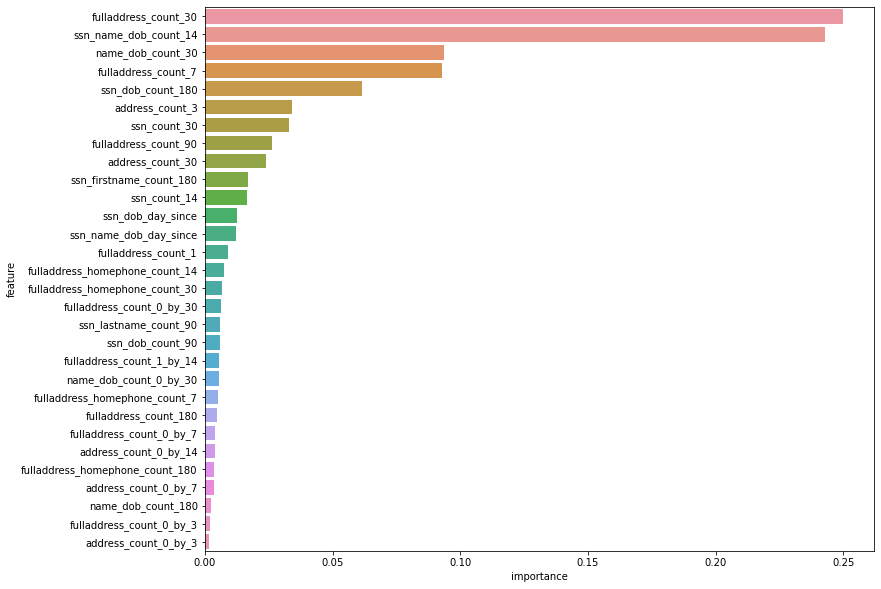

In [187]:
fig = plt.figure(figsize=(12,10))
sns.barplot(data=importance, y='feature',x='importance')

In [ ]:
#model = LogisticRegression(penalty='l2', class_weight='balanced')
#rfecv = RFECV(estimator=model, step=1, cv=2, verbose=0, n_jobs=1, scoring="roc_auc")
#rfecv.fit(wrapper_df1,data['fraud_label'])